# Visualizing data flow in a simple neural network for house prices

This notebook shows how to create an animated visualization of the data flow within a trained simple neural network.

The main purpose is to provide intuition about the way input data is processed within each layer of the network and how the interplay of weights, biases and layer activations comes together, resulting in a particular prediction.

To achieve this, I:

1. Define architecture of a simple feed-forward neural network and train it (using Pytorch)
2. Use three pieces of information to visualize the data flow in the network:
    - information about the network architecture (number of layers and nodes etc)
    - example input data
    - dictionaries of weights, biases and output values within the trained network applied to the input data

Dataset used is California Housing Data. It consists of 20,640 samples and 9 features. The data is a bit old, being sourced during 1990 US census.
Here you can find the [dataset description provided by Google](https://developers.google.com/machine-learning/crash-course/california-housing-data-description)


Visualization is performed using 
- Networkx (to represent the neural network as a graph)
- Matplotlib to plot the graph
- PIL.Image and io.BytesIO in order to store the series of images representing the network states as a gif



# Part 1: Training the network

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import r2_score

import pandas as pd
import numpy as np

from io import BytesIO
from PIL import Image

import networkx as nx
import matplotlib.pyplot as plt

import random
from datetime import date

from typing import Callable, Tuple, Any, List


In [182]:
# Load and prepare California Housing Dataset
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# Load the California housing dataset
california_housing = fetch_california_housing()

# Access the data and target attributes
X, y = california_housing.data, california_housing.target

In [183]:
# Quick look at the data
x_df = pd.DataFrame(X)
x_df.columns = california_housing.feature_names
x_df['target'] = y
x_df["coordinates"] = x_df["Latitude"] * x_df["Longitude"]

In [184]:
x_df.corr().sort_values('target')

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target,coordinates
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160,-0.996464
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701,-0.052111
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967,0.953217
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650,0.108357
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737,-0.001225
coordinates,0.060215,-0.032359,-0.090134,-0.052111,0.108357,-0.001225,-0.996464,0.953217,0.104524,1.000000
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623,-0.032359
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948,-0.090134
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075,0.060215
target,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000,0.104524


In [192]:
# Leaving the key features
x_df = x_df[['MedInc', 'HouseAge', 'AveRooms', 'Population']]
X = x_df.to_numpy()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [194]:
# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.from_numpy(X_train).float()
y_tensor = torch.from_numpy(y_train).float().view(-1, 1)

X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().view(-1, 1)

In [271]:
# Define the neural network architecture
input_dim = X_tensor.shape[1]
out_dim = y_tensor.shape[1]

# Can be modified to add more hidden layers
hidden_layers_output_dimensions = {
    'fc1': 7,
    'fc2': 5,
    'fc3': 8,
}

class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        i = 1
        layer_input_dim = input_dim
        for layer_name, layer_out_dim in hidden_layers_output_dimensions.items():
            # create a hidden layer
            setattr(self, layer_name, nn.Linear(layer_input_dim, layer_out_dim))
            layer_input_dim = layer_out_dim
            # add activation
            setattr(self, f"relu{i}", nn.ReLU())
            i += 1
        self.output_layer = nn.Linear(layer_input_dim, out_dim)

    def forward(self, x):
        # forward pass through hidden layers
        for n, layer_name in enumerate(hidden_layers_output_dimensions.keys()):
            l = getattr(self, layer_name)
            relu = getattr(self, f"relu{n+1}")
            x = relu(l(x))
        # forward pass towards the output layer
        x = self.output_layer(x)
        return x
    
def predict(model, X_test):
    # Set the model to evaluation mode
    model.eval()

    # Make predictions
    with torch.no_grad():
        return model(X_test)

In [272]:
# Instantiate the model
model = FeedForwardNN()

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.006)

# Training the model
for epoch in range(6000):
    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    
y_pred = predict(model, X_test_tensor)
r2 = r2_score(y_test_tensor, y_pred)
print(f'R2 score (0-1): {r2:.4f}')

R2 score (0-1): 0.5456


# Part 2: Visualizing the network's data flow

### Generating step by step data flow for example input datapoint

In [139]:
def hook_fn(name: str) -> Callable:
    """
    Function to register hooks for each layer
    
    Parameters:
    - name (str): Name to identify the layer. Used to store data in dictionaries.

    Returns:
    Callable: Hook function to register with PyTorch model layers.
    The hook function records the input and output data of the layer during forward pass.
    """
    def hook(module, input, output):
        input_data_dict[name] = input[0].detach().numpy()
        output_data_dict[name] = output.detach().numpy()

    return hook

In [273]:
dummy_input = X_test_tensor[0]
output = model(dummy_input)

input_data_dict = {}
output_data_dict = {}

In [274]:
# Register the hooks for each layer
for name, layer in model.named_children():
    layer.register_forward_hook(hook_fn(name))

# Pass the input through the model to trigger the hooks
output = model(dummy_input)

In [141]:
def get_pos_limits(graph: nx.DiGraph) -> Tuple[Tuple[float, float], Tuple[float, float]]:
    """
    Function to determine limits of x an y axis of matplotlib graphs in order
    to have a stable plot size as more nodes are subsequently added to the visualized network.
    Plot size is determined based on the full network graph's layout dictionary (listing positions
    of all nodes in the graph). Xlim and ylim is then set by adding some "padding" to the edge
    positions of the nodes.
    
    Parameters:
    - graph (nx.DiGraph): graph of the full trained network with all nodes and edges

    Returns:
    Tuples of min and max values defining xlim and ylim for a matplotlib plot
    """
    pos = nx.get_node_attributes(G, 'pos')
    pos_reversed = {node: (x, -y) for node, (x, y) in pos.items()}
    
    x_max = np.max([v[0] for k,v in pos_reversed.items()]) + 2
    x_min = np.min([v[0] for k,v in pos_reversed.items()]) - 2

    y_max = np.max([v[1] for k,v in pos_reversed.items()]) + 2
    y_min = np.min([v[1] for k,v in pos_reversed.items()]) - 2
    
    return (x_min, x_max), (y_min, y_max)

### Helper functions for creating plots for the gif (step by step network visualization)

In [408]:
def format_label(label: float | np.float32 | Any) -> float | np.float32 | Any:
    """
    Formats float node labels by rounding them to 2nd decimal
    
    Parameters:
    - label (Any): node label, possibly float in need of rounding

    Returns:
    Rounded node label if it was float, unchanged node label otherwise
    """
    if isinstance(label, float) or isinstance(label, np.float32):
        return f'{label:.2f}'
    else:
        return label

In [704]:
def draw_plot(graph: nx.DiGraph,
              x_lim: Tuple[float, float],
              y_lim: Tuple[float, float],
              title:str="",
              show: bool=False) -> BytesIO:
    """
    Draws a plot of the current graph state
    
    Parameters:
    - graph (nx.DiGraph): current graph state
    - xlim (Tuple): min and max value for the x axis of the plot
    - ylim (Tuple): min and max value for the y axis of the plot
    - title (str): plot title
    - show (bool): whether to show the plot in the notebook after generating it

    Returns:
    Bytestream of the plot for future storage within the gif
    """
    pos = nx.get_node_attributes(graph, 'pos')
    pos_reversed = {node: (x, -y) for node, (x, y) in pos.items()}      
    
    width = abs(max(y_lim, key=abs))
    heigth = abs(max(x_lim, key=abs))
    fig, ax = plt.subplots(figsize=(width, heigth))
    
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    
    node_colors = [graph.nodes[node]['color'] for node in graph.nodes]
    node_labels = {label: format_label(label) for label, data in graph.nodes(data=True)}

    # Plot the graph
    nx.draw(graph, 
            pos_reversed,
            with_labels=True,
            labels=node_labels,
            node_size=1000,
            node_color=node_colors,
            edgecolors='darkcyan',
            node_shape='8',
            font_size=8,
            linewidths=0.7,
            font_color="black", 
            edge_color = 'grey',
            style='dashed',
            width=0.8,
            arrowsize=12)
    
    labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos_reversed, edge_labels=labels, font_size=8)
    
    title_font = {'fontname': 'Norasi', 'size': '16', 'color': 'black'}
    plt.title(title, **title_font)
    plt.tight_layout()
    
    signature_text = 'linkedin.com/in/mariam-khuchua'
    plt.text(0.05, 0.05, signature_text, color='grey', fontsize=10,
            va='bottom', ha='left', transform=ax.transAxes)

    fig.set_facecolor("whitesmoke")
    ax.axis('off')
    plt.rcParams['savefig.facecolor']='whitesmoke'
    
    # Save the plot to a BytesIO object
    img_stream = BytesIO()    
    plt.savefig(img_stream, format='png')
    img_stream.seek(0)
    
    if show:
        plt.show()
    # Close the plot to free up resources
    plt.close()
    
    return img_stream

In [327]:
# Create full graph (to evaluate final plot size)
G = nx.DiGraph()

input_layer_name = "input"
layer_n=0

# Add nodes for input layer
for i in range(input_dim):
    G.add_node(f'{input_layer_name}_{i}', pos=(layer_n, i), color='mediumturquoise')
layer_n += 1

# Add nodes for hidden layers
layer_input_dim = input_dim
previous_layer_name = input_layer_name

for layer_name, layer_out_dim in hidden_layers_output_dimensions.items():
    for i in range(layer_out_dim):
        # add nodes for the current layer
        G.add_node(f'{layer_name}_{i}', pos=(layer_n, i), color='paleturquoise')
        # add edges from previous layer to current layer
        for j in range(layer_input_dim):
            G.add_edge(f'{previous_layer_name}_{j}', f'{layer_name}_{i}')
    layer_input_dim = layer_out_dim
    previous_layer_name = layer_name
    layer_n += 1


# Add node and edges for output layer
for i in range(out_dim):
    G.add_node(f'Output_{i}', pos=(layer_n, i), color='mediumaquamarine')
    for j in range(layer_input_dim):
        G.add_edge(f'{previous_layer_name}_{j}', f'Output_{i}')
        

# Determine plot limits
x_lim, y_lim = get_pos_limits(G)

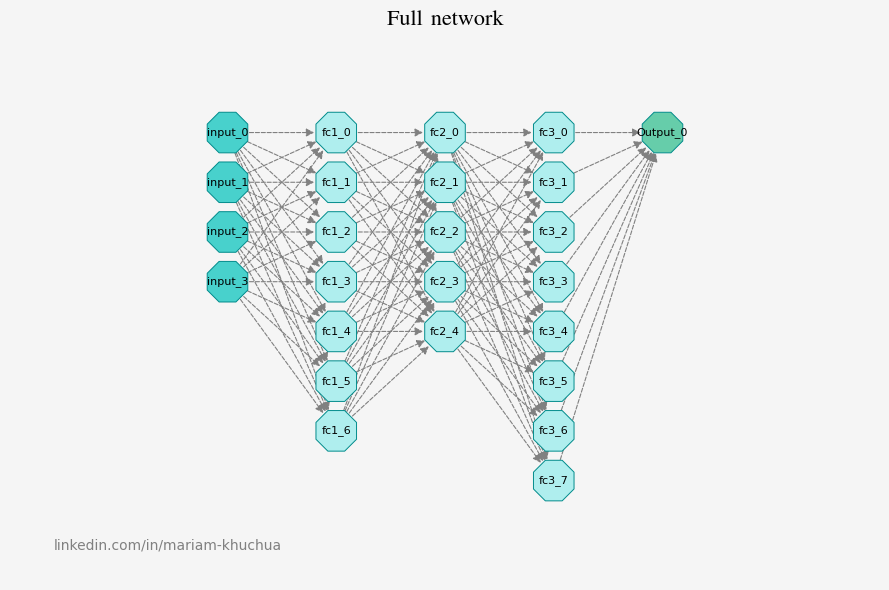

In [710]:
# Shows full network and gives an idea how the step-by-step gif will look like
_ = draw_plot(G, x_lim, y_lim, title="Full network", show=True)

In [718]:
def add_hidden_layer(graph: nx.DiGraph,
                     layer_input: np.array,
                     layer_output: np.array,
                     weights: torch.Tensor,
                     biases: torch.Tensor,
                     layer_n:int,
                     color:str,
                     layer_name:str,
                     remove_edges:bool=True) -> Tuple[nx.DiGraph, List[BytesIO]]:
    """
    Adds a hidden layer to the graph and creates the related plot
    
    Parameters:
    - graph (nx.DiGraph): current graph state
    - layer_input (np.array): node values of the previous layer
    - layer_output (np.array): node values of the current layer
    - weights (torch.Tensor): tensor with hidden layer's weights
    - biases (torch.Tensor): tensor with hidden layer's biases
    - layer_n (int): layer number within the graph (starting with 0)
    - color (str): color for the layer nodes
    - layer_name (str): layer name for plot title parsing
    - remove_edges (bool): parameter determining whether to delete edges before returning the graph
    
    Returns:
    - graph - an updated graph
    - hidden_plots - a list of plots related to the hidden layer (edges between previous layer to the nodes of this layer)
    """
    
    
    hidden_plots = []
    # for each node of the current layer, create it and all incoming weight & bias edges
    for node_i in range(len(layer_output)):
        # create layer node
        output = float(layer_output[node_i])
        graph.add_node(output, pos=(layer_n, node_i), color=color)
        for prev_layer_node_j in range(len(layer_input)):
            weight = np.round(float(weights[node_i, prev_layer_node_j]), 2)
            bias = np.round(float(biases[node_i]), 2)
            # create labelled input edge from non-zero nodes of the previous layer to the current layer node
            if layer_input[prev_layer_node_j] != 0:
                graph.add_edge(layer_input[prev_layer_node_j], output, weight=f'* {weight} +') 
        # create an edge representing bias
        graph.add_edge(f"bias_{layer_n}", output, weight=f'{bias} +')
        # create plot of the current graph state
        plot = draw_plot(graph, x_lim=x_lim, y_lim=y_lim, title=f"{layer_name} layer: weights and biases")
        hidden_plots.append(plot)
        # temporarily remove edges to the node (to keep the plot humanly readable)
        if remove_edges:
            removable_edges = [v for v in list(graph.edges()) if v[0] in list(layer_input) + [f"bias_{layer_n}"]]
            graph.remove_edges_from(removable_edges)
    
    return graph, hidden_plots

In [714]:
def apply_relu(graph: nx.DiGraph,
               hidden_layer_input: np.array,
               hidden_layer_output: np.array,
               relu_output: np.array,
               layer_n: int,
               color:str,
               layer_name:str,
              )-> Tuple[nx.DiGraph, List[BytesIO]]:
    
    """
    Adds a hidden layer to the graph and creates the related plot
    
    Parameters:
    - graph (nx.DiGraph): current graph state
    - hidden_layer_input (np.array):
    - hidden_layer_output (np.array):
    - relu_output (np.array):
    - layer_n (int): layer number within the graph (starting with 0)
    - color (str): color for the layer nodes
    - layer_name (str): layer name for plot title parsing
    
    Returns:
    - graph - an updated graph
    - hidden_plots - a list of plots related to the hidden layer (edges between previous layer to the nodes of this layer)
    """
    graph.remove_nodes_from(hidden_layer_output)
    zeroes = []
    
    hidden_plots = []
    for node_i in range(len(hidden_layer_output)):
        output = float(relu_output[node_i])
        # To avoid duplication of zero nodes
        if output == 0:
            output = output + random.uniform(1e-5, 1e-10)
            zeroes.append(output)
        graph.add_node(output, pos=(layer_n, node_i), color=color)
        for prev_layer_node_j in range(len(hidden_layer_input)):
            if hidden_layer_input[prev_layer_node_j] != 0:
                graph.add_edge(hidden_layer_input[prev_layer_node_j], output)
                graph.add_edge(f"bias_{layer_n}", output)
    plot = draw_plot(graph, x_lim=x_lim, y_lim=y_lim, title=f"{layer_name} layer: RELU activation")
    hidden_plots.append(plot)
    
    # remove zeroes
    graph.remove_nodes_from(zeroes)
    plot = draw_plot(graph, x_lim=x_lim, y_lim=y_lim, title=f"{layer_name} layer: RELU activation")
    hidden_plots.append(plot)
    
    return graph, hidden_plots


### Creating the plots for different "stages" of the data flow within the network

In [719]:
plots = []

G1 = nx.DiGraph()

bias_counter = 1
pos_counter = 0


# Input layer
next_layer_name = next(iter(input_data_dict))
for i in range(input_dim):
    G1.add_node(float(dummy_input[i]), pos=(pos_counter, i), color='mediumturquoise')
    
G1.add_node(f"bias_{bias_counter}", pos=(pos_counter, -1), color='lavender')
bias_counter += 1
pos_counter += 1

plot = draw_plot(G1, x_lim=x_lim, y_lim=y_lim, title="Input")
plots.append(plot)

# Hidden layers and activations 
for layer_name in hidden_layers_output_dimensions.keys():
   
    G1.add_node(f"bias_{bias_counter}", pos=(pos_counter, -1), color='lavender')
    bias_counter += 1
    
    # Layer
    
    G1, hidden_plots = add_hidden_layer(graph=G1,
                                        layer_input=input_data_dict[layer_name],
                                        layer_output=output_data_dict[layer_name],
                                        weights=getattr(model, layer_name).weight.data ,
                                        biases=getattr(model, layer_name).bias.data,
                                        layer_n=pos_counter,
                                        color='aquamarine',
                                        layer_name=f'{pos_counter}. hidden')

    plots.extend(hidden_plots)
    
    # RELU activation

    G1, hidden_plots = apply_relu(graph=G1,
                                  hidden_layer_input=input_data_dict[layer_name],
                                  hidden_layer_output=input_data_dict[f'relu{pos_counter}'],
                                  relu_output=output_data_dict[f'relu{pos_counter}'],
                                  layer_n=pos_counter,
                                  color="paleturquoise",
                                  layer_name=f'{pos_counter}. hidden')

    plots.extend(hidden_plots)
    pos_counter += 1

# Output layer
G1, hidden_plots = add_hidden_layer(graph=G1,
                                    layer_input=output_data_dict[f'relu{pos_counter-1}'],
                                    layer_output=output_data_dict['output_layer'],
                                    weights=model.output_layer.weight.data,
                                    biases=model.output_layer.bias.data,
                                    layer_n=pos_counter,
                                    color='mediumaquamarine',
                                    layer_name='Output',
                                    remove_edges=False)

plots.extend(hidden_plots * 3)

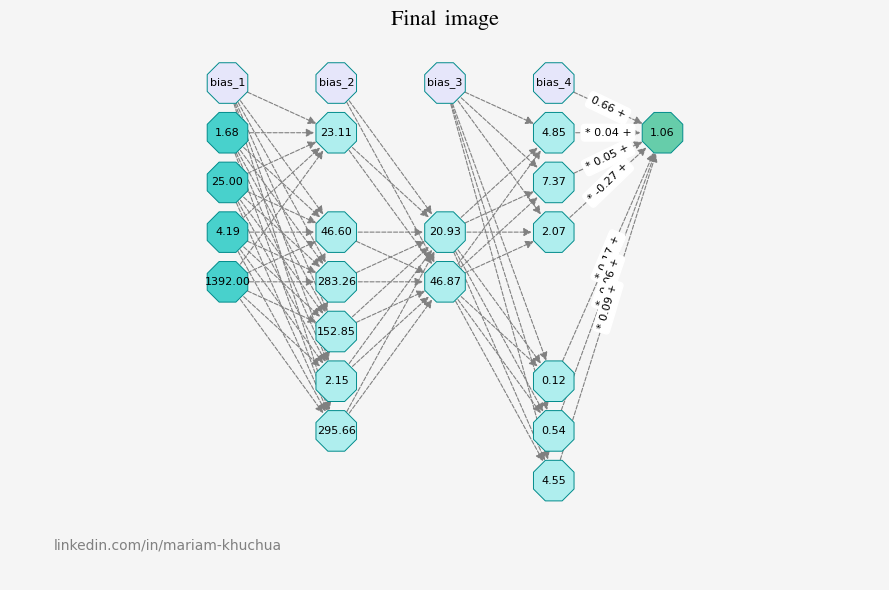

In [720]:
_ = draw_plot(G1, x_lim=x_lim, y_lim=y_lim, title="Final image", show=True)

In [721]:
# Save the plots as a GIF
today = date.today().strftime("%Y_%m_%d")
images = [Image.open(plot) for plot in plots]
gif_path = f'network_{today}.gif'
images[0].save(gif_path, save_all=True, append_images=images[1:], duration=600, loop=0)

## Load and display gif

In [5]:
from IPython.display import display, HTML

In [4]:
display(HTML(f'<img src="{gif_path}">'))